# Fitting PADH patient

## Packages

In [1]:
import sys
sys.path.append('../datasets') 
import dataset_long as dsl

sys.path.append('../fitting') 
import paramfitt_singlePatient as pf 

# Model
import numpy as np
import tellurium as te
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Dataframe
import pandas as pd

#Estimation

from scipy.optimize import minimize 
from collections import OrderedDict
from scipy.stats import qmc
from scipy.optimize import basinhopping
#Analyse Estimation
from scipy.stats import chi2
from scipy.stats import norm

# Save optimization params
import json
import time

## PADH fitted model 


In [2]:

size_of_font = 22


# Define lab and additional values
lab_values = ['[iE]','[oiE]', '[E]', '[R]', 'Hb', 'Hkt', 'RPI', 'LDH'] # pf.get_lab_values()
additional_values = [] #['k_E_death', '[iE]', '[P]', 'J_P_death']
all_values = lab_values + additional_values

# experimentel data
patient = '36'
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, patient, lab_values)

# define Units dictionary
units_dict = {'[iE]':1e4, '[oiE]':1e4, '[E]':1e6, 'Hb':1, '[P]':1, '[R]':1e4, 'Hkt': 1, 'LDH':1, 'RPI':1} 

# Load optimization results
with open ('.././fitting/20230903-08-59-54paras_optimized.json', 'r') as jsonfile:    #r= only read #new with fixed function
#with open ('.././fitting/20230710-10-54-21paras_optimized.json', 'r') as jsonfile:    #r= only read # old for thesis
    optimize_results_file = json.load(jsonfile, object_pairs_hook=OrderedDict)

#new parameter
new_dict = optimize_results_file["results"][0]["best_params"]

# Update model with new parameters
ant_model = '.././model/OIE_model.ant'
ant_model = te.loada(ant_model)
ant_model = pf.update_model(ant_model, new_dict)

print(ant_model.Hkt_init)

#print(ant_model.t_ART_add)

# Simulate the model
res = ant_model.simulate(0, 40, 10000, selections=['time']+ all_values)
df_simulated_data = pd.DataFrame(res, columns=res.colnames)

# Adjust time in experimental data
df_experimental_data['time'] = df_experimental_data.index + 10**new_dict['t_ART_add']


# times uncertainty
time_uncertainty = [0,0,2,3,4]

# Define number of rows and columns for the subplots
n_subplots = len(all_values)
n_cols = 4
n_rows = int(np.ceil(n_subplots/n_cols))

# Create subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(22,10))  #(20,15)  #15,8
fig.subplots_adjust(hspace=0.4 ,wspace= 0.5)

# Loop over all lab values and create a plot for each
for i, lab_value in enumerate(all_values):
    col = i%n_cols
    row = i//n_cols
    ax[row, col].plot(df_simulated_data.time, df_simulated_data[lab_value]/units_dict[lab_value], color = 'tab:red',  label = 'Simulation',  linewidth=2)
    if lab_value in df_experimental_data.columns:   
        #ax[row, col].plot(df_experimental_data.time, df_experimental_data[lab_value]/units_dict[lab_value] ,'s',  markersize=5, color = 'tab:purple',  linewidth=2, label = 'PADH Patient Data')
        ax[row, col].errorbar(df_experimental_data.time, df_experimental_data[lab_value]/units_dict[lab_value], xerr=time_uncertainty, fmt='s', markersize=5, color='tab:purple', linewidth=2, label='PADH Patient Data')
    #print(df_experimental_data)
     #xerr = time_uncertainty[df_experimental_data.index],

    time_ART_add = 10**new_dict['t_ART_add']
    ax[row, col].axvspan(time_ART_add, time_ART_add+0.3, facecolor='gainsboro', alpha=1, label='ACT Administration', linewidth=2)
    ax[row, col].axvspan(time_ART_add+1, time_ART_add+1.3, facecolor='gainsboro', alpha=1,  linewidth=2)
    ax[row, col].axvspan(time_ART_add+2, time_ART_add+2.3, facecolor='gainsboro', alpha=1,  linewidth=2)

    ax[row, col].tick_params(labelsize=size_of_font) # Größe Achseneinteilungen (zahlen)
    ax[row, col].set_xlabel('time (days)', fontsize= size_of_font)

    if lab_value == 'Hb': ax[row, col].set_ylabel('Hb (g/dl)', fontsize= size_of_font) 
    elif lab_value == '[R]': ax[row, col].set_ylabel('R (1e4/µl)', fontsize= size_of_font)
    elif lab_value == '[oiE]': ax[row, col].set_ylabel('oiE (1e4/µl)', fontsize= size_of_font)
    elif lab_value == '[E]': ax[row, col].set_ylabel('E (1e6/µl)', fontsize= size_of_font)   
    elif lab_value == '[iE]': ax[row, col].set_ylabel('iE (1e4/µl)', fontsize= size_of_font) 
    elif lab_value == 'Hkt': ax[row, col].set_ylabel('Hkt', fontsize= size_of_font)   
    elif lab_value == 'LDH': ax[row, col].set_ylabel('LDH (U/l)', fontsize= size_of_font)   
    elif lab_value == 'RPI': ax[row, col].set_ylabel('RPI', fontsize= size_of_font)  
    else: ax[row, col].set_ylabel(f'{lab_value} ({units_dict[lab_value]}/µl)', fontsize= size_of_font)
    
    ax[row, col].legend(fontsize = size_of_font, loc='upper right') # Größe legende

    handles, labels = ax[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots
    fig.legend(handles, labels, loc='lower center',   bbox_to_anchor=(0.5, -0.15),  fontsize= size_of_font)
    #0.5, -0.11
    ax[row, col].get_legend().remove()  # entfernt Legende aus einzelnen Plots

plt.savefig("./figures/paramfit_PADH.pdf", format="pdf", bbox_inches='tight')
plt.show()




FileNotFoundError: [Errno 2] No such file or directory: '.././fitting/20230903-08-59-54paras_optimized.json'

### all plots of fit

2.6358992742345384


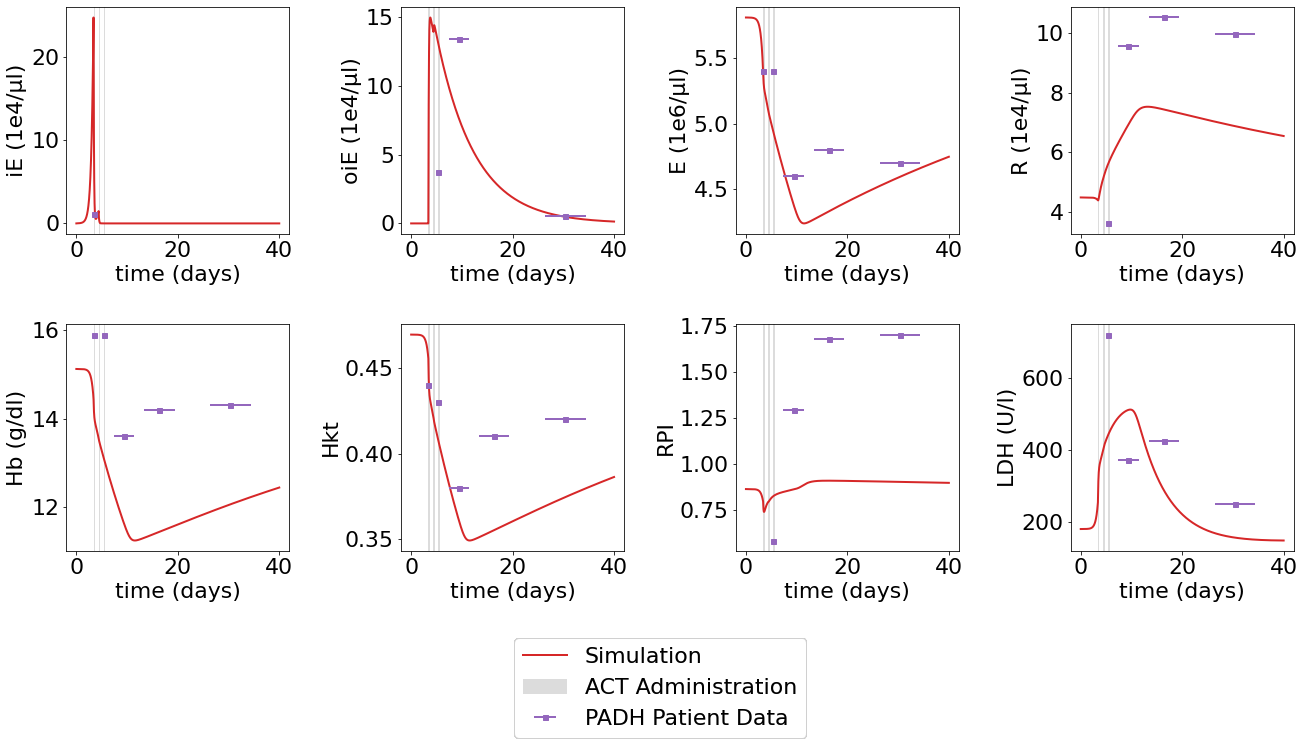

2.5724276157558137


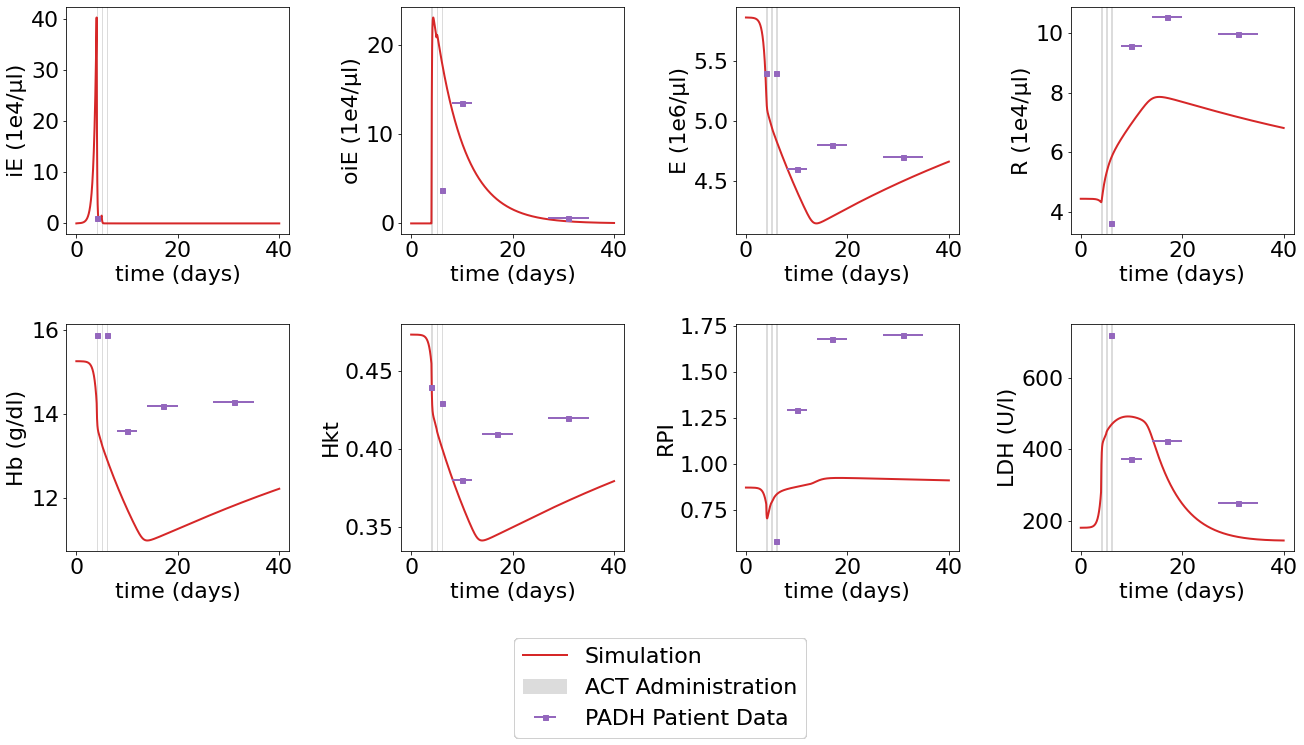

2.4781583986953093


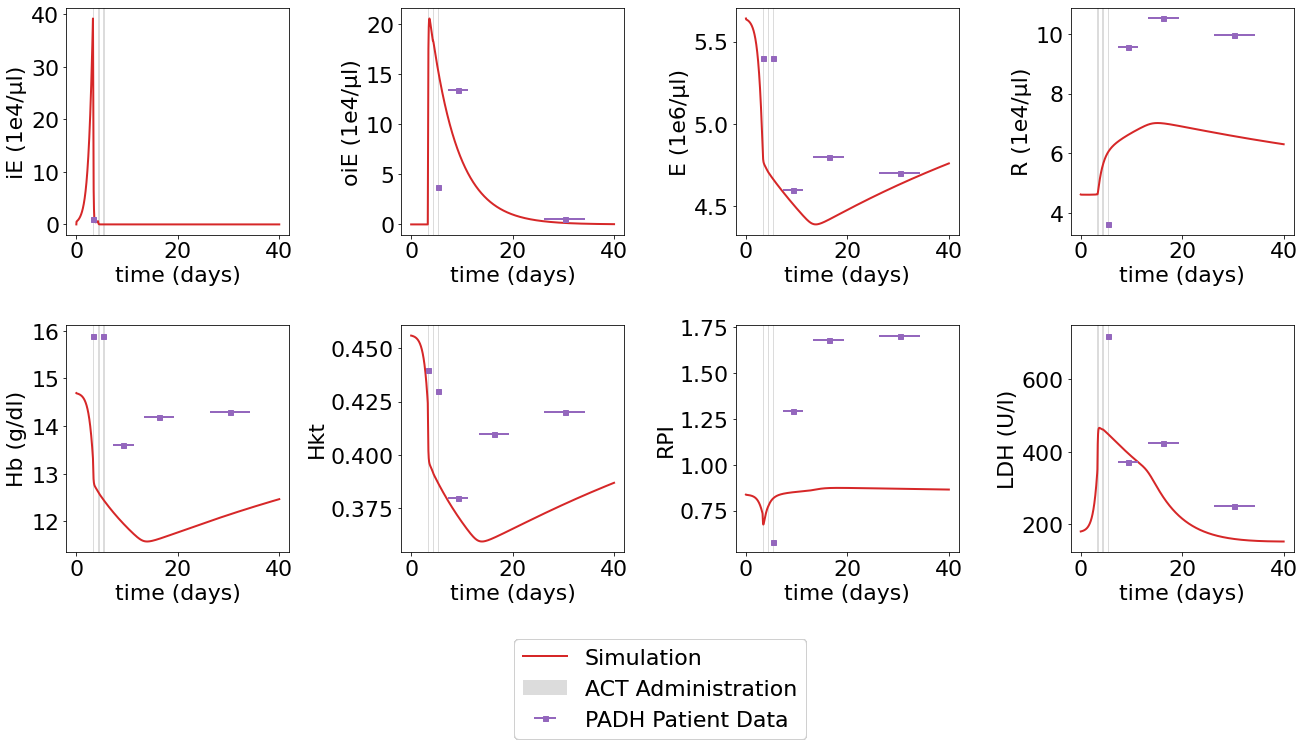

2.3705288461590066


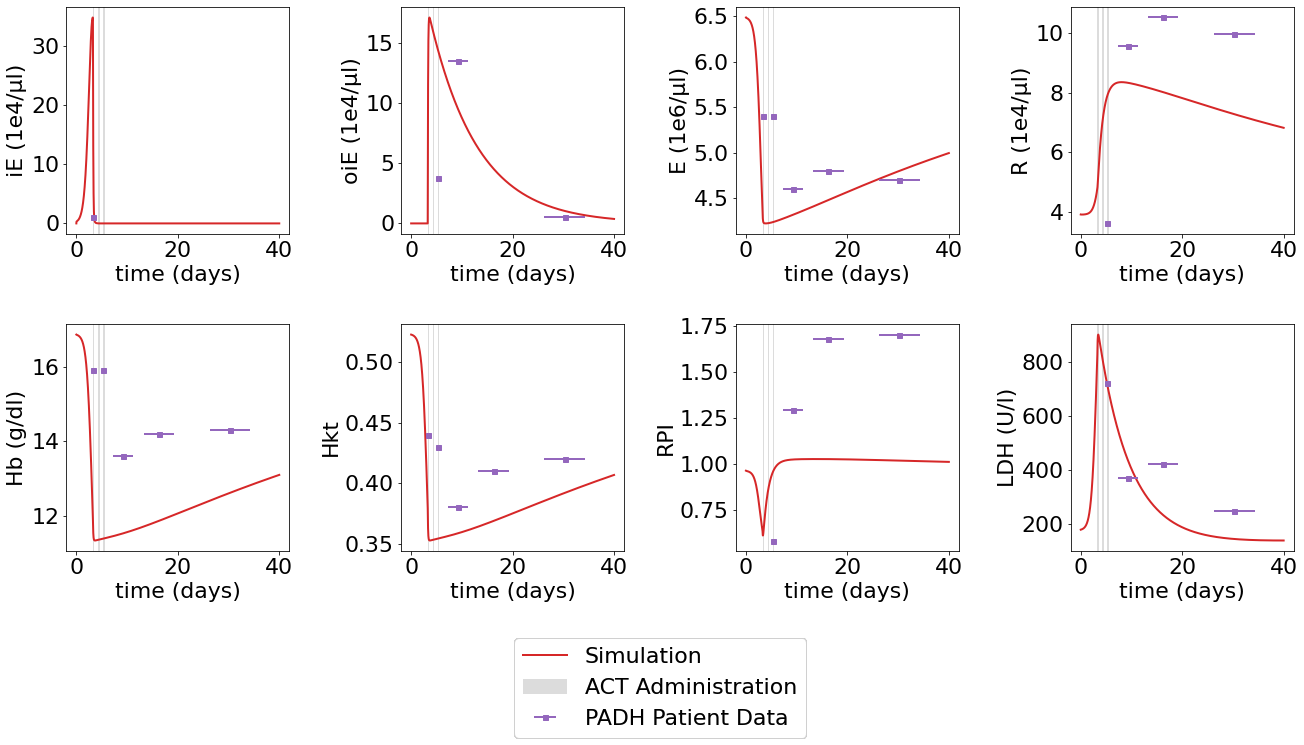

2.5541732398757033


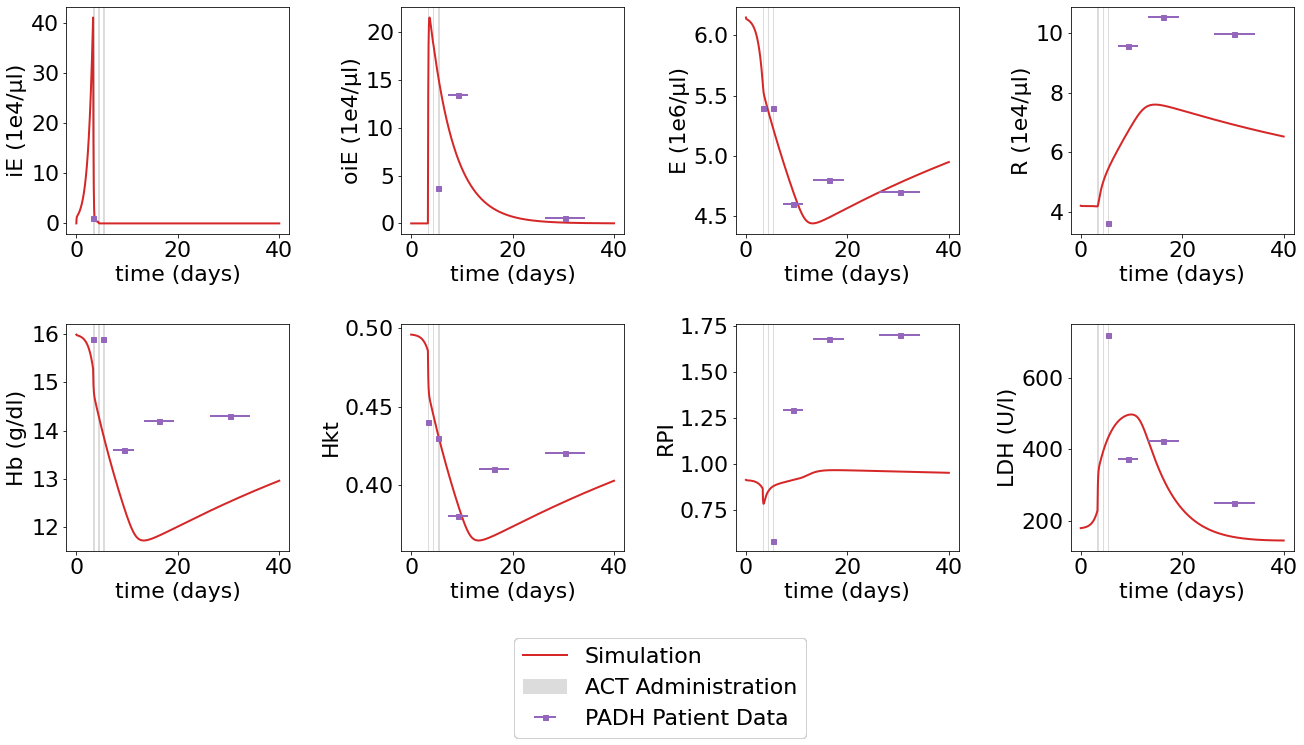

In [ ]:

size_of_font = 22


# Define lab and additional values
lab_values = ['[iE]','[oiE]', '[E]', '[R]', 'Hb', 'Hkt', 'RPI', 'LDH'] # pf.get_lab_values()
additional_values = [] #['k_E_death', '[iE]', '[P]', 'J_P_death']
all_values = lab_values + additional_values

# experimentel data
patient = '36'
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, patient, lab_values)

# define Units dictionary
units_dict = {'[iE]':1e4, '[oiE]':1e4, '[E]':1e6, 'Hb':1, '[P]':1, '[R]':1e4, 'Hkt': 1, 'LDH':1, 'RPI':1} 

# Load optimization results
with open ('.././fitting/20230904-13-42-04paras_optimized_2_36.json', 'r') as jsonfile:   #maxtiter 1000
#with open ('.././fitting/20230903-08-59-54paras_optimized.json', 'r') as jsonfile:    #r= only read #new with fixed function
#with open ('.././fitting/20230710-10-54-21paras_optimized.json', 'r') as jsonfile:    #r= only read # old for thesis
    optimize_results_file = json.load(jsonfile, object_pairs_hook=OrderedDict)

#new parameter
#for i in range(len(optimize_results_file["results"])):

new_dict = optimize_results_file["results"][0]["best_params"]

# Update model with new parameters
ant_model = '.././model/OIE_model.ant'
ant_model = te.loada(ant_model)
ant_model = pf.update_model(ant_model, new_dict)

print(optimize_results_file["results"][i]["best_score"])

#print(ant_model.t_ART_add)

# Simulate the model
res = ant_model.simulate(0, 40, 10000, selections=['time']+ all_values)
df_simulated_data = pd.DataFrame(res, columns=res.colnames)

# Adjust time in experimental data
df_experimental_data['time'] = df_experimental_data.index + 10**new_dict['t_ART_add']


# times uncertainty
time_uncertainty = [0,0,2,3,4]

# Define number of rows and columns for the subplots
n_subplots = len(all_values)
n_cols = 4
n_rows = int(np.ceil(n_subplots/n_cols))

# Create subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(22,10))  #(20,15)  #15,8
fig.subplots_adjust(hspace=0.4 ,wspace= 0.5)

# Loop over all lab values and create a plot for each
for i, lab_value in enumerate(all_values):
    col = i%n_cols
    row = i//n_cols
    ax[row, col].plot(df_simulated_data.time, df_simulated_data[lab_value]/units_dict[lab_value], color = 'tab:red',  label = 'Simulation',  linewidth=2)
    if lab_value in df_experimental_data.columns:   
        #ax[row, col].plot(df_experimental_data.time, df_experimental_data[lab_value]/units_dict[lab_value] ,'s',  markersize=5, color = 'tab:purple',  linewidth=2, label = 'PADH Patient Data')
        ax[row, col].errorbar(df_experimental_data.time, df_experimental_data[lab_value]/units_dict[lab_value], xerr=time_uncertainty, fmt='s', markersize=5, color='tab:purple', linewidth=2, label='PADH Patient Data')
    #print(df_experimental_data)
    #xerr = time_uncertainty[df_experimental_data.index],

    time_ART_add = 10**new_dict['t_ART_add']
    ax[row, col].axvspan(time_ART_add, time_ART_add+0.3, facecolor='gainsboro', alpha=1, label='ACT Administration', linewidth=2)
    ax[row, col].axvspan(time_ART_add+1, time_ART_add+1.3, facecolor='gainsboro', alpha=1,  linewidth=2)
    ax[row, col].axvspan(time_ART_add+2, time_ART_add+2.3, facecolor='gainsboro', alpha=1,  linewidth=2)

    ax[row, col].tick_params(labelsize=size_of_font) # Größe Achseneinteilungen (zahlen)
    ax[row, col].set_xlabel('time (days)', fontsize= size_of_font)

    if lab_value == 'Hb': ax[row, col].set_ylabel('Hb (g/dl)', fontsize= size_of_font) 
    elif lab_value == '[R]': ax[row, col].set_ylabel('R (1e4/µl)', fontsize= size_of_font)
    elif lab_value == '[oiE]': ax[row, col].set_ylabel('oiE (1e4/µl)', fontsize= size_of_font)
    elif lab_value == '[E]': ax[row, col].set_ylabel('E (1e6/µl)', fontsize= size_of_font)   
    elif lab_value == '[iE]': ax[row, col].set_ylabel('iE (1e4/µl)', fontsize= size_of_font) 
    elif lab_value == 'Hkt': ax[row, col].set_ylabel('Hkt', fontsize= size_of_font)   
    elif lab_value == 'LDH': ax[row, col].set_ylabel('LDH (U/l)', fontsize= size_of_font)   
    elif lab_value == 'RPI': ax[row, col].set_ylabel('RPI', fontsize= size_of_font)  
    else: ax[row, col].set_ylabel(f'{lab_value} ({units_dict[lab_value]}/µl)', fontsize= size_of_font)
    
    ax[row, col].legend(fontsize = size_of_font, loc='upper right') # Größe legende

    handles, labels = ax[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots
    fig.legend(handles, labels, loc='lower center',   bbox_to_anchor=(0.5, -0.15),  fontsize= size_of_font)
    #0.5, -0.11
    ax[row, col].get_legend().remove()  # entfernt Legende aus einzelnen Plots

plt.savefig("./figures/paramfit_PADH.pdf", format="pdf", bbox_inches='tight')
plt.show()




## PADH check: Hb Drop & LDH Increase

In [ ]:
"""PADH check in measured Data"""

Hb_drop_patient = (df_experimental_data['Hb'][0]- df_experimental_data['Hb'].min()) / df_experimental_data['Hb'][0]
LDH_increase_patient = (df_experimental_data['LDH'][0]- df_experimental_data['Hb'].max()) / df_experimental_data['Hb'][0]   # not possible da non  data on day 0


print(Hb_drop_patient, LDH_increase_patient)

0.14465408805031452 nan


In [ ]:
""" Hb decrease in fitted model """

desired_time = 10**new_dict['t_ART_add']
closest_time_row = df_simulated_data[df_simulated_data["time"] <= desired_time]
Hb_at_t_ART_add = closest_time_row['Hb'].iloc[-1]

# Identify the row that is closest to but not exceeding the desired time + 8
closest_post_interval_time_row = df_simulated_data[df_simulated_data["time"] < desired_time + 8].iloc[-1]

# Find max of LDH which occurs at least 8 days after t_ART_add
post_interval_data = df_simulated_data[df_simulated_data["time"] >= closest_post_interval_time_row['time']]
minimum_Hb_post_interval = post_interval_data['Hb'].max()

# % decrease
Hb_decrease_percent = (minimum_Hb_post_interval - Hb_at_t_ART_add)/ Hb_at_t_ART_add

Hb_decrease_percent, Hb_at_t_ART_add, minimum_Hb_post_interval

(-0.13922854050407593, 14.458510590112395, 12.44547326278832)

In [ ]:
""" LDH Increase in fitted model """

desired_time = 10**new_dict['t_ART_add']
closest_time_row = df_simulated_data[df_simulated_data["time"] <= desired_time]
ldh_at_t_ART_add = closest_time_row['LDH'].iloc[-1]

# Identify the row that is closest to but not exceeding the desired time + 8
closest_post_interval_time_row = df_simulated_data[df_simulated_data["time"] < desired_time + 8].iloc[-1]

# Find max of LDH which occurs at least 8 days after t_ART_add
post_interval_data = df_simulated_data[df_simulated_data["time"] >= closest_post_interval_time_row['time']]
maximum_ldh_post_interval = post_interval_data['LDH'].max()

# % increase
ldh_increase_percent = (maximum_ldh_post_interval - ldh_at_t_ART_add)/ ldh_at_t_ART_add

ldh_increase_percent, ldh_at_t_ART_add, maximum_ldh_post_interval

(0.8705986103211281, 254.30604837966746, 475.7045406952635)